## 1. 环境设置与导入

In [3]:
import os
import numpy as np
import dotenv
from openai import OpenAI
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib
from typing import List, Tuple, Dict

# 设置 Matplotlib 支持中文显示
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

# 加载环境变量 (如果需要 API)
dotenv.load_dotenv()
# 确保 API 密钥和 Base URL 已设置 (如果使用 API 模型)
# os.environ["OPENAI_API_KEY"] = os.getenv("API_KEY")
# os.environ["OPENAI_BASE_URL"] = os.getenv("BASE_URL")

False

## 2. 辅助函数定义

In [4]:
# 通用函数：获取嵌入 (支持本地 & API)
def get_embeddings(texts: List[str], model_name: str, use_local: bool = False) -> np.ndarray:
    if use_local:
        print(f"使用本地模型加载: {model_name}")
        model = SentenceTransformer(model_name, trust_remote_code=True)
        # 本地模型支持直接归一化
        embeddings = model.encode(texts, normalize_embeddings=True)
        print(f"本地模型嵌入生成完毕，形状: {embeddings.shape}")
        return embeddings
    else:
        print(f"使用 API 模型: {model_name}")
        client = OpenAI(api_key=os.getenv("API_KEY"), base_url=os.getenv("BASE_URL"))
        resp = client.embeddings.create(input=texts, model=model_name)
        emb = np.array([d.embedding for d in resp.data])
        # API 模型通常需要手动归一化以进行准确的余弦相似度比较
        norms = np.linalg.norm(emb, axis=1, keepdims=True)
        normalized_emb = emb / norms
        print(f"API 模型嵌入生成并归一化完毕，形状: {normalized_emb.shape}")
        return normalized_emb # 返回归一化后的嵌入

In [5]:
# 计算余弦相似度 (假设输入向量已归一化)
def cosine_similarity_normalized(a: np.ndarray, b: np.ndarray) -> float:
    # 对于已归一化的向量，点积即余弦相似度
    return float(np.dot(a, b))

In [6]:
# 运行实验函数
def run_experiment(pairs: List[Tuple[str, str]], model_name: str, use_local: bool = False) -> List[Dict[str, any]]: # 返回类型改为 List[Dict]
    print(f"\n--- 开始实验: 模型='{model_name}', 本地={use_local} ---")
    texts_a = [p[0] for p in pairs]
    texts_b = [p[1] for p in pairs]
    all_texts = texts_a + texts_b
    
    try:
        embeddings = get_embeddings(all_texts, model_name, use_local)
    except Exception as e:
        print(f"获取嵌入时出错: {e}")
        return [] # 返回空列表
        
    n = len(pairs)
    results: List[Dict[str, any]] = [] # 初始化为空列表
    print("计算相似度...")
    for i, (a, b) in enumerate(pairs):
        # 使用归一化向量的点积计算相似度
        sim = cosine_similarity_normalized(embeddings[i], embeddings[i + n])
        # 存储完整信息
        result_item = {'text_a': a, 'text_b': b, 'similarity': sim}
        results.append(result_item)
        # 打印时仍可用截断键名，或打印完整文本
        print(f"  '{a[:20]}...' vs '{b[:20]}...': {sim:.4f}")
    print(f"--- 实验结束: 模型='{model_name}' ---")
    return results

In [7]:
# 可视化函数
def plot_results(results: List[Dict[str, any]], title: str): # 输入类型改为 List[Dict]
    """
    可视化实验结果（余弦相似度），并用颜色标示与第一个结果的差异。
    Args:
        results: 一个字典列表，每个字典包含 'text_a', 'text_b', 'similarity'。
        title: 图表的标题（字符串）。
    """
    # 设置 Matplotlib 支持中文显示
    matplotlib.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
    matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
    
    # 从字典列表中提取用于绘图的数据
    keys = [f"{item['text_a'][:20]}... vs {item['text_b'][:20]}..." for item in results]
    vals = [item['similarity'] for item in results]

    if not vals: # 处理空结果的情况
        print(f"没有结果可供绘制: {title}")
        return

    # 创建图表，设置更合适的画布大小
    fig, ax = plt.subplots(figsize=(max(12, len(keys) * 1.5), 6)) # 根据标签数量调整宽度

    # 定义颜色
    base_color = 'lightblue'
    higher_color = 'lightcoral' # 比基准高的颜色
    lower_color = 'lightgreen' # 比基准低的颜色

    # 获取基准值（第一个结果的相似度）
    base_value = vals[0]

    # 绘制条形图，并根据与基准值的比较设置颜色
    colors = [base_color] # 第一个柱子用基准色
    for val in vals[1:]:
        if val > base_value:
            colors.append(higher_color)
        elif val < base_value:
            colors.append(lower_color)
        else:
            colors.append(base_color) # 与基准值相等也用基准色

    bars = ax.bar(keys, vals, color=colors, width=0.6)

    # 设置图表标题，并调整字体大小
    ax.set_title(title, fontsize=16, pad=20)

    # 设置Y轴范围，留出顶部空间显示数值
    min_val = min(vals) if vals else 0
    max_val = max(vals) if vals else 1
    ax.set_ylim(min(0, min_val - 0.1), max(1, max_val + 0.15)) # 动态调整Y轴范围
    # 添加Y轴标签
    ax.set_ylabel("余弦相似度", fontsize=12)

    # 设置X轴刻度标签，旋转角度以便阅读，并调整字体大小
    ax.set_xticks(np.arange(len(keys))) # 确保刻度位置正确
    ax.set_xticklabels(keys, rotation=30, ha='right', fontsize=10) # 调整旋转角度

    # 添加水平网格线，设置样式和透明度，提高可读性
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7) # 使用虚线网格

    # 在每个条形上方精确显示数值和内部显示与基准的差异
    for i, bar in enumerate(bars):
        y = bar.get_height()
        # 显示数值 (在柱子上方)
        ax.text(bar.get_x() + bar.get_width() / 2, y + 0.01, f"{y:.3f}",
                 ha='center', va='bottom', fontsize=9)
        # 显示与基准的差异（第一个柱子除外，显示在柱子内部靠近顶部）
        if i > 0:
            diff = y - base_value
            diff_text = f"{diff:+.3f}" # 带符号显示差异
            diff_color = 'red' if diff < 0 else 'green' if diff > 0 else 'gray'
            # 将差异文本放在柱子内部，稍微低于顶部
            ax.text(bar.get_x() + bar.get_width() / 2, y - 0.01 if y > 0 else y + 0.02, diff_text, # 调整负值文本位置
                     ha='center', va='top' if y > 0 else 'bottom', fontsize=8, color=diff_color, fontweight='bold')

    # 添加图例说明颜色含义，并将其放置在图表外部右侧
    # 更新图例中的基准值显示
    legend_elements = [Patch(facecolor=base_color, edgecolor='gray', label=f'基准值 ({base_value:.3f})'),
                       Patch(facecolor=higher_color, edgecolor='gray', label='高于基准'),
                       Patch(facecolor=lower_color, edgecolor='gray', label='低于基准')]
    # 将图例放置在轴域 (Axes) 的右上方外部
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, borderaxespad=0.)

    # 自动调整子图参数，使之填充整个图像区域，防止标签重叠
    fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例

    # 显示图表
    plt.show()

## 3. 模型路径定义

In [8]:
# 本地模型路径 (请确保路径正确)
jina_model_path = "/root/XiaokeAILabs/jina-embeddings-v3"
bge_m3_model_path = "/root/XiaokeAILabs/bge-m3"
bge_large_zh_v1_5_model_path = "/root/XiaokeAILabs/bge-large-zh-v1.5"


# 要测试的模型列表
models_to_test = [
    {"name": "Local BGE-M3", "path_or_name": bge_m3_model_path, "local": True},
    {"name": "Local BGE-Large-ZH-v1.5", "path_or_name": bge_large_zh_v1_5_model_path, "local": True},
    {"name": "Local Jina-V3", "path_or_name": jina_model_path, "local": True}, 
]

## 4. 实验数据定义

定义用于不同实验场景的文本对。

In [9]:
# 实验 1: 代码与文本 (增加代码与代码对比)
code_snippet = """def add(a, b):\n    return a + b"""
text_desc_1 = "这是一个计算两个数之和的函数。"
text_desc_2 = "我是一个用来计算两个数之和的函数"
# 带注释的代码片段
code_snippet_2_with_comments = """
# Function to add two numbers
def sum_numbers(x, y):
    # Returns the sum of x and y
    result = x + y
    return result
"""
# 另一个不带注释的相似代码片段
code_snippet_3_no_comments = """
def sum_two_values(val1, val2):
    s = val1 + val2
    return s
"""
# 另一个带注释的相似代码片段
code_snippet_4_with_comments = """
# This function takes two arguments and returns their sum.
def calculate_sum(num1, num2):
    # Perform addition
    total = num1 + num2
    # Return the result
    return total
"""

code_text_pairs = [
    (code_snippet, text_desc_1),                     # 代码(无注释) vs 文本描述1
    (code_snippet, text_desc_2),                     # 代码(无注释) vs 文本描述2
    (text_desc_1, text_desc_2),                      # 文本描述1 vs 文本描述2
    (code_snippet, code_snippet_2_with_comments),    # 代码(无注释) vs 代码(有注释)
    (code_snippet, code_snippet_3_no_comments),      # 代码(无注释) vs 代码(无注释) - 新增
    (code_snippet_2_with_comments, code_snippet_3_no_comments), # 代码(有注释) vs 代码(无注释) - 新增
    (code_snippet_2_with_comments, code_snippet_4_with_comments), # 代码(有注释) vs 代码(有注释) - 新增
    (text_desc_1, code_snippet_2_with_comments), # 文本描述1 vs 代码(有注释) - 新增
]

# 实验 2: 文本与表格 (增加表格与表格对比)
text_table_desc_1 = "这是一个关于不同水果信息的表格。"
text_table_desc_2 = "这个表格展示了苹果、香蕉和柠檬的颜色和味道。"
text_table_desc_3 = "水果信息：苹果是红色的，味道甜；香蕉是黄色的，味道甜；柠檬是黄色的，味道酸。"
text_table_desc_4 = "这是一段关于天气的文字，与水果表格无关。"
table_markdown = """| 水果   | 颜色 | 味道 |\n|------|----|----|\n| 苹果   | 红色 | 甜   |\n| 香蕉   | 黄色 | 甜   |\n| 柠檬   | 黄色 | 酸   |"""
# 新增：另一个相似的 Markdown 表格 (内容稍作修改)
table_markdown_2 = """| Fruit  | Color  | Taste  |\n|--------|--------|--------|\n| Apple  | Red    | Sweet  |\n| Banana | Yellow | Sweet  |\n| Orange | Orange | Sweet  |""" # 内容稍作修改
# 新增：结构相同，内容和表头完全不同的表格
table_markdown_3_diff_content = """| 城市   | 人口(万) | GDP(亿) |\n|------|-------|-------|\n| 北京   | 2189  | 40269 |\n| 上海   | 2487  | 43214 |\n| 广州   | 1867  | 28231 |"""

text_table_pairs = [
    (text_table_desc_1, table_markdown),
    (text_table_desc_2, table_markdown),
    (text_table_desc_3, table_markdown),
    (text_table_desc_4, table_markdown),
    (text_table_desc_1, text_table_desc_2),
    (text_table_desc_1, text_table_desc_3),
    (text_table_desc_2, text_table_desc_3),
    (text_table_desc_1, text_table_desc_4),
    (table_markdown, table_markdown_2), # 表格 vs 表格 (相似内容)
    (table_markdown, table_markdown_3_diff_content) # 表格 vs 表格 (结构相同，内容不同) - 新增
]

# 实验 3: 查询与目标 (保持不变)
# --- 代码检索查询 ---
query_code_precise = "Python 函数：计算 a 和 b 的和"
query_code_purpose = "用于两数相加的函数，基于python"
query_code_keyword = "python add function"
query_code_vague = "计算"
query_code_wrong_lang = "Java add method"
# --- 表格检索查询 ---
query_table_specific_q = "柠檬是什么味道的？"
query_table_summary = "水果颜色和味道概览"
query_table_col_focus = "表格里有哪些水果？"
query_table_vague = "水果"
query_table_related_concept = "食物营养成分"
# --- 通用查询 ---
query_irrelevant = "最近的电影推荐"

# --- 查询配对 ---
# 使用 code_snippet 作为代码目标
query_code_pairs = [
    (query_code_precise, code_snippet),      # 精确匹配查询 vs 代码
    (query_code_purpose, code_snippet),      # 目的性查询 vs 代码
    (query_code_keyword, code_snippet),      # 关键词查询 vs 代码
    (query_code_vague, code_snippet),        # 模糊查询 vs 代码
    (query_code_wrong_lang, code_snippet),   # 错误语言查询 vs 代码
    (query_table_specific_q, code_snippet),  # 表格相关查询 vs 代码 (应低相关)
    (query_irrelevant, code_snippet),        # 无关查询 vs 代码 (应极低相关)
    (query_code_precise, query_code_purpose),# 代码查询 vs 代码查询
]
# 使用 table_markdown 作为表格目标
query_table_pairs = [
    (query_table_specific_q, table_markdown),# 具体问题查询 vs 表格
    (query_table_summary, table_markdown),   # 总结性查询 vs 表格
    (query_table_col_focus, table_markdown), # 列焦点查询 vs 表格
    (query_table_vague, table_markdown),     # 模糊查询 vs 表格
    (query_table_related_concept, table_markdown), # 相关概念查询 vs 表格 (应较低相关)
    (query_code_precise, table_markdown),    # 代码相关查询 vs 表格 (应低相关)
    (query_irrelevant, table_markdown),      # 无关查询 vs 表格 (应极低相关)
    (query_table_specific_q, query_table_summary), # 表格查询 vs 表格查询
]

# 将所有实验组合 (实验名称保持不变，但内容已更新)
all_experiments = {
    "代码与文本相似度": code_text_pairs,
    "文本与表格相似度": text_table_pairs,
    "查询(代码)与目标相似度": query_code_pairs,
    "查询(表格)与目标相似度": query_table_pairs
}

## 5. 运行实验并可视化结果

对每个定义的模型运行所有实验，并为每个模型生成结果图表。


==================== 开始处理模型: Local BGE-M3 ====================

--- 开始实验: 模型='/root/XiaokeAILabs/bge-m3', 本地=True ---
使用本地模型加载: /root/XiaokeAILabs/bge-m3
本地模型嵌入生成完毕，形状: (16, 1024)
计算相似度...
  'def add(a, b):
    r...' vs '这是一个计算两个数之和的函数。...': 0.6526
  'def add(a, b):
    r...' vs '我是一个用来计算两个数之和的函数...': 0.6447
  '这是一个计算两个数之和的函数。...' vs '我是一个用来计算两个数之和的函数...': 0.9149
  'def add(a, b):
    r...' vs '
# Function to add t...': 0.6930
  'def add(a, b):
    r...' vs '
def sum_two_values(...': 0.6694
  '
# Function to add t...' vs '
def sum_two_values(...': 0.6571
  '
# Function to add t...' vs '
# This function tak...': 0.8296
  '这是一个计算两个数之和的函数。...' vs '
# Function to add t...': 0.6381
--- 实验结束: 模型='/root/XiaokeAILabs/bge-m3' ---

--- 开始实验: 模型='/root/XiaokeAILabs/bge-m3', 本地=True ---
使用本地模型加载: /root/XiaokeAILabs/bge-m3
本地模型嵌入生成完毕，形状: (20, 1024)
计算相似度...
  '这是一个关于不同水果信息的表格。...' vs '| 水果   | 颜色 | 味道 |
|...': 0.6372
  '这个表格展示了苹果、香蕉和柠檬的颜色和味...' vs '| 水果   | 颜色 | 味道 |
|...': 0.7334
  '水果信息：苹果是红色的，味

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 36825 (\N{CJK UNIFIED IDEOGRAPH-8FD9}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans

本地模型嵌入生成完毕，形状: (16, 1024)
计算相似度...
  '柠檬是什么味道的？...' vs '| 水果   | 颜色 | 味道 |
|...': 0.5173
  '水果颜色和味道概览...' vs '| 水果   | 颜色 | 味道 |
|...': 0.6708
  '表格里有哪些水果？...' vs '| 水果   | 颜色 | 味道 |
|...': 0.5338
  '水果...' vs '| 水果   | 颜色 | 味道 |
|...': 0.5663
  '食物营养成分...' vs '| 水果   | 颜色 | 味道 |
|...': 0.4220
  'Python 函数：计算 a 和 b 的...' vs '| 水果   | 颜色 | 味道 |
|...': 0.2979
  '最近的电影推荐...' vs '| 水果   | 颜色 | 味道 |
|...': 0.1715
  '柠檬是什么味道的？...' vs '水果颜色和味道概览...': 0.4375
--- 实验结束: 模型='/root/XiaokeAILabs/bge-large-zh-v1.5' ---
==================== 模型处理完毕: Local BGE-Large-ZH-v1.5 ====================


==================== 开始处理模型: Local Jina-V3 ====================
警告: 本地模型路径不存在，跳过模型 'Local Jina-V3': /root/XiaokeAILabs/jina-embeddings-v3
实验结果已成功写入文件: ./experiment_results_summary.txt

--- 可视化模型结果: Local BGE-M3 ---


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

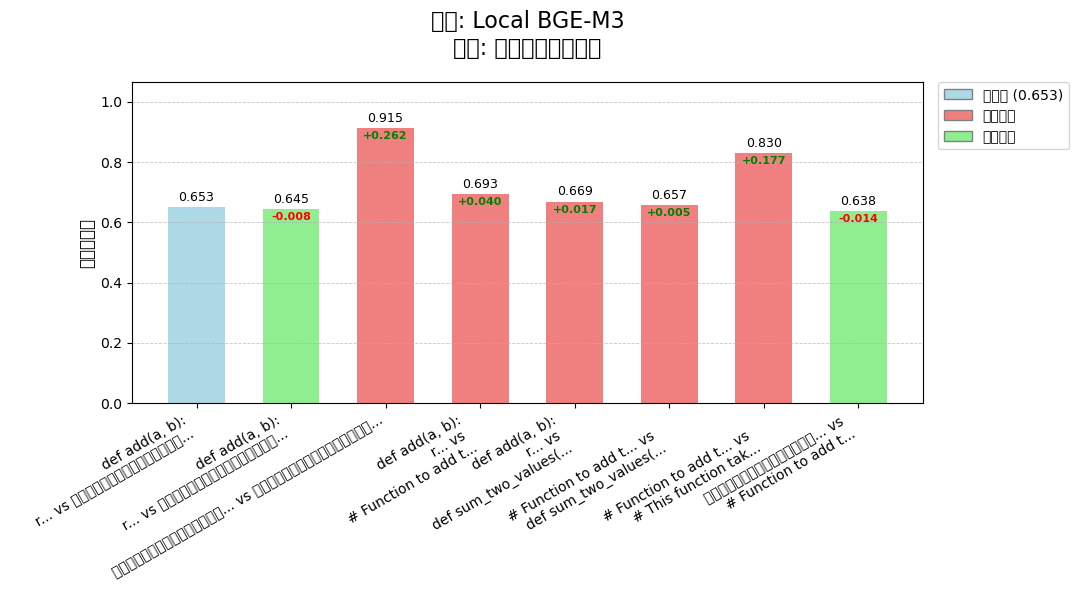

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 36825 (\N{CJK UNIFIED IDEOGRAPH-8FD9}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning:

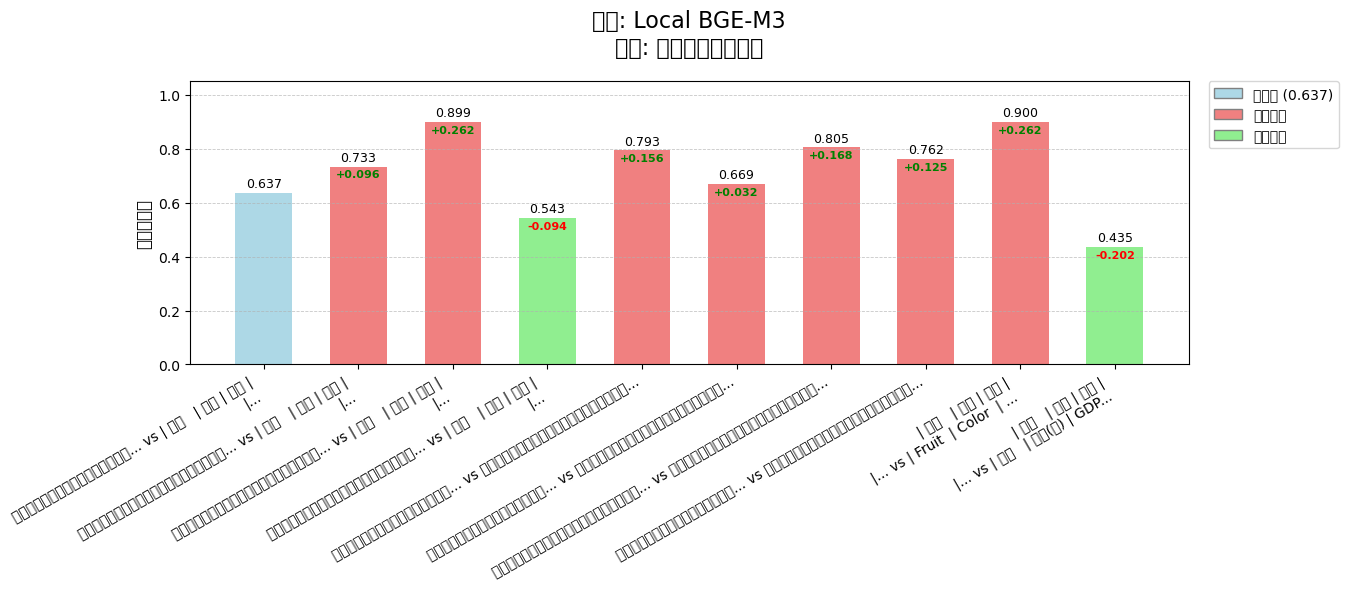

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 3163

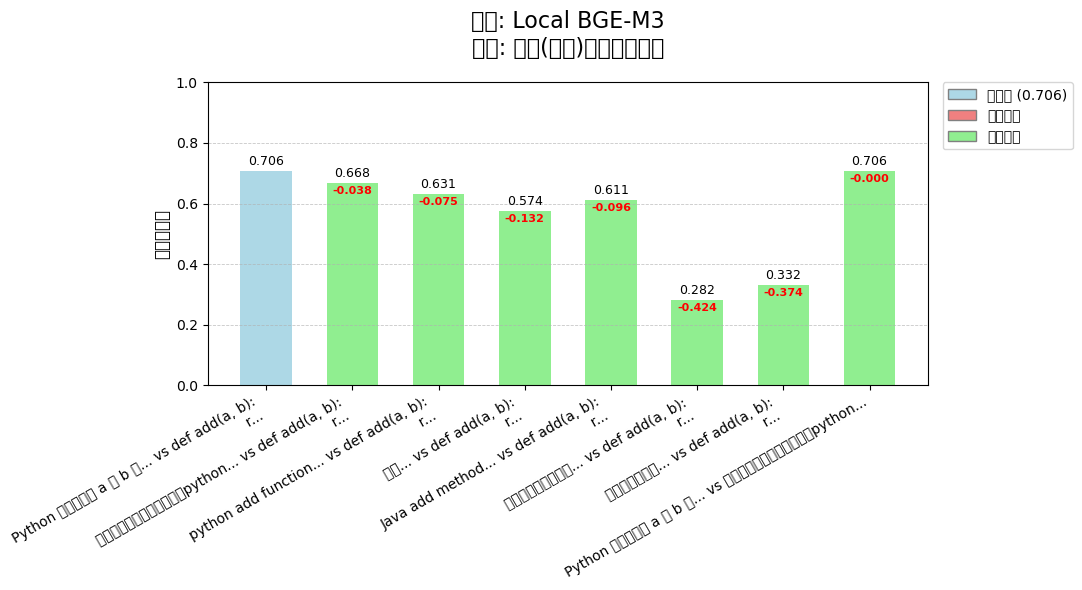

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26592 (\N{CJK UNIFIED IDEOGRAPH-67E0}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 27308 (\N{CJK UNIFIED IDEOGRAPH-6AAC}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20160 (\N{CJK UNIFIED IDEOGRAPH-4EC0}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning:

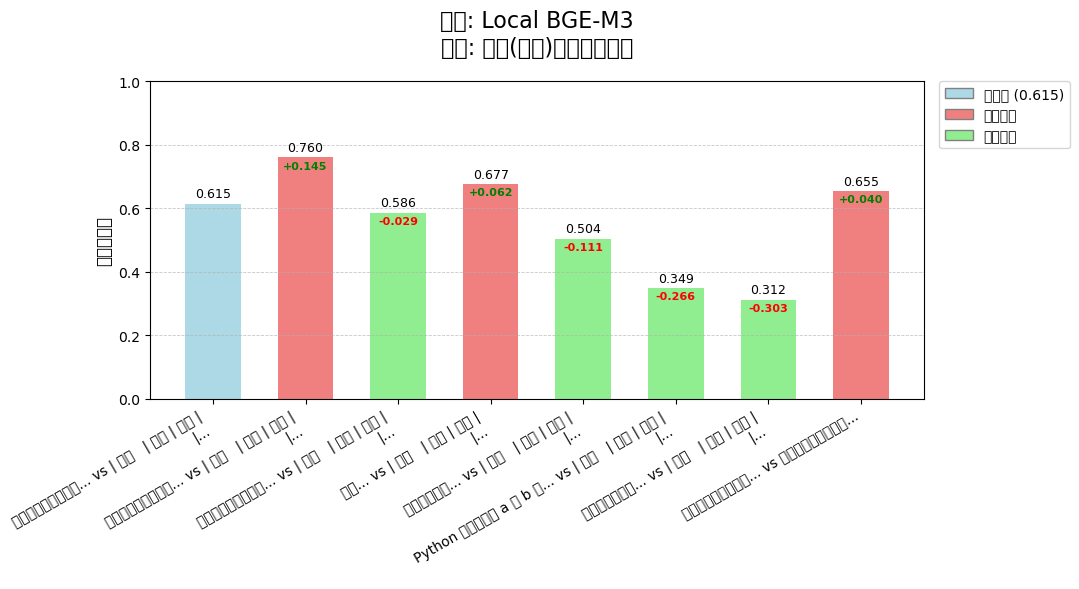

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 36825 (\N{CJK UNIFIED IDEOGRAPH-8FD9}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans


--- 可视化模型结果: Local BGE-Large-ZH-v1.5 ---


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/usr/local/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24358 (\N{CJK UNIFIED IDEOGRAPH-5F26}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/anaconda3/lib/python3.1

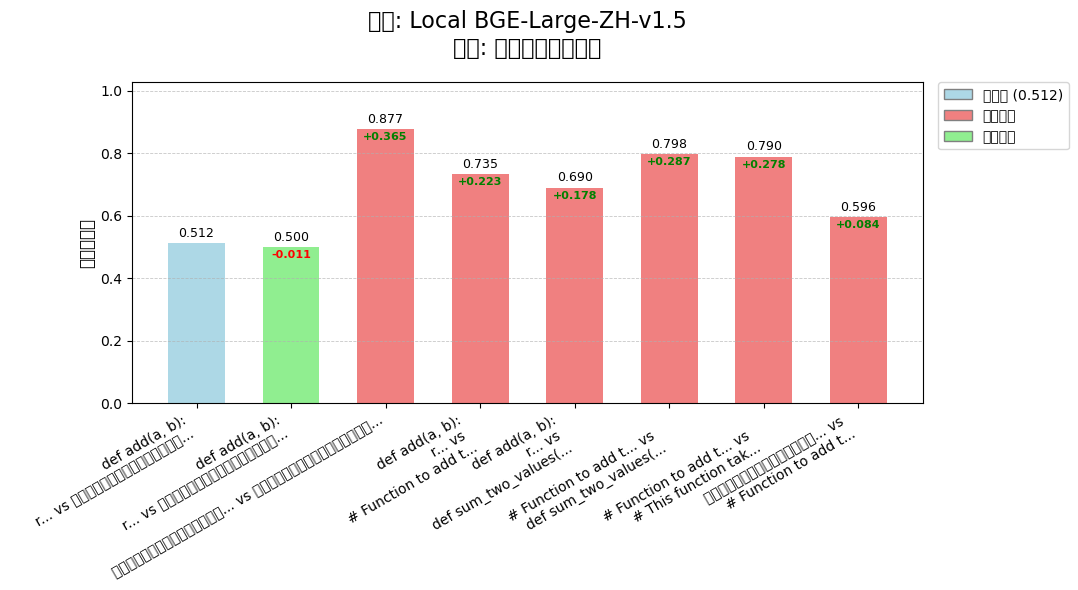

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 36825 (\N{CJK UNIFIED IDEOGRAPH-8FD9}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning:

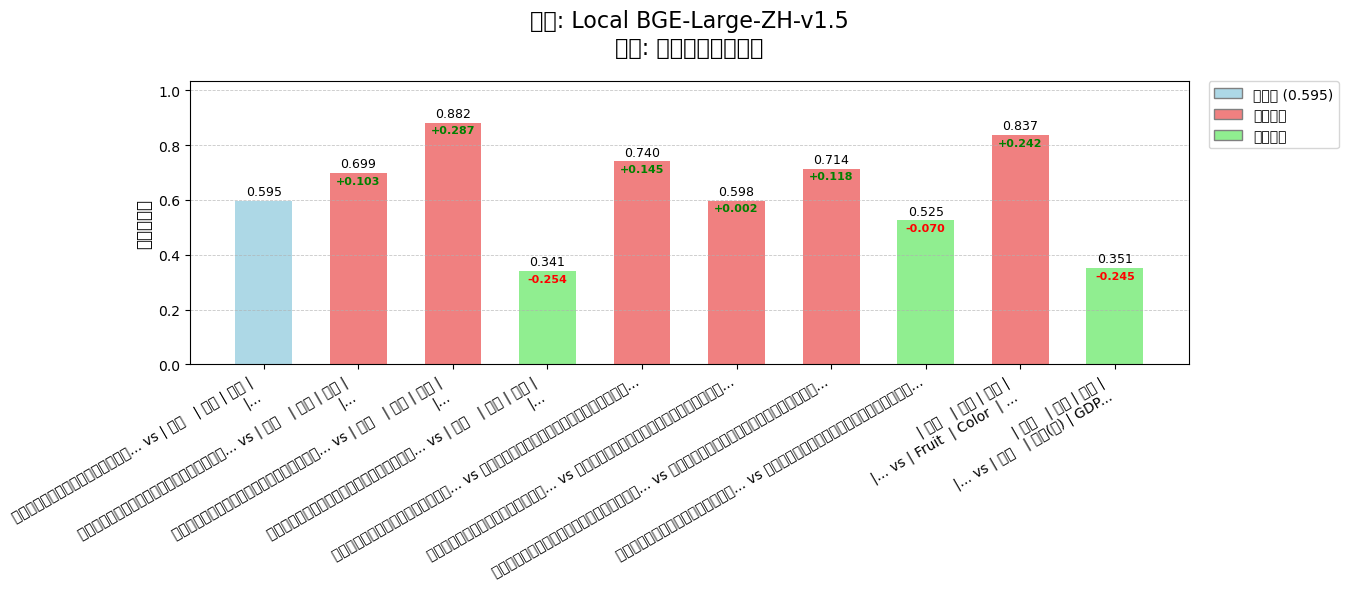

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 3163

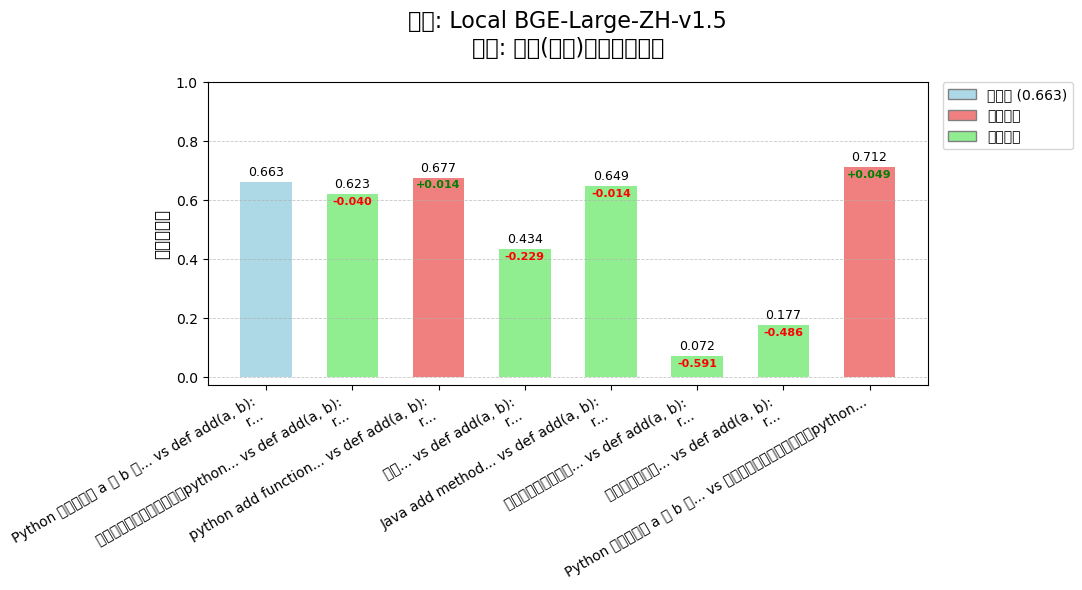

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26592 (\N{CJK UNIFIED IDEOGRAPH-67E0}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 27308 (\N{CJK UNIFIED IDEOGRAPH-6AAC}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning: Glyph 20160 (\N{CJK UNIFIED IDEOGRAPH-4EC0}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以容纳图例
/tmp/ipykernel_251589/3461119268.py:85: UserWarning:

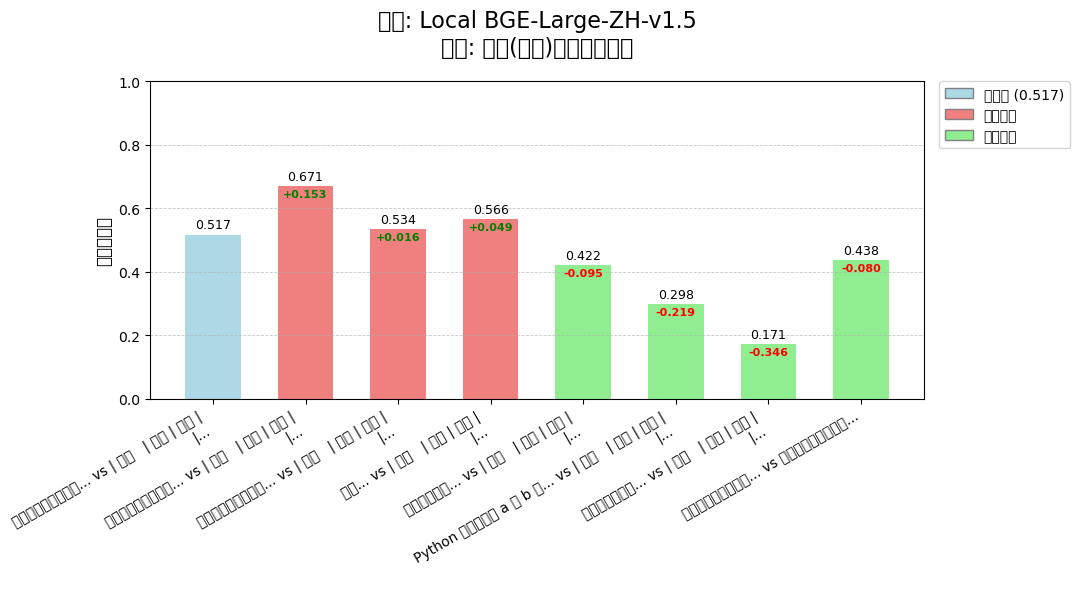

In [10]:
all_results_by_model = {}

for model_info in models_to_test:
    model_name = model_info["name"]
    model_path_or_name = model_info["path_or_name"]
    use_local = model_info["local"]
    
    print(f"\n{'='*20} 开始处理模型: {model_name} {'='*20}")
    model_results = {}
    
    # 检查本地模型路径是否存在
    if use_local and not os.path.exists(model_path_or_name):
        print(f"警告: 本地模型路径不存在，跳过模型 '{model_name}': {model_path_or_name}")
        continue
        
    for exp_name, pairs in all_experiments.items():
        # run_experiment 现在返回 List[Dict]
        results = run_experiment(pairs, model_path_or_name, use_local)
        model_results[exp_name] = results
        
    all_results_by_model[model_name] = model_results
    print(f"{'='*20} 模型处理完毕: {model_name} {'='*20}\n")

# --- 修改代码：将实验结果汇总写入文件 ---
output_filepath = "./experiment_results_summary.txt"
try:
    with open(output_filepath, 'w', encoding='utf-8') as f:
        f.write("="*30 + " 实验结果汇总 " + "="*30 + "\n")
        for model_name, experiments in all_results_by_model.items():
            f.write(f"\n## 模型: {model_name}\n")
            for exp_name, results_list in experiments.items(): # results 现在是列表
                f.write(f"\n### 实验: {exp_name}\n")
                if results_list:
                    for item in results_list: # 遍历列表中的每个字典
                        text_a = item['text_a']
                        text_b = item['text_b']
                        similarity = item['similarity']
                        # 写入完整的 text_a 和 text_b
                        # 使用 repr() 来处理可能包含换行符的字符串
                        f.write(f"- {repr(text_a)} vs {repr(text_b)}: {similarity:.4f}\n")
                else:
                    f.write("- (无结果)\n")
        f.write("\n" + "="*30 + " 结果汇总结束 " + "="*30 + "\n")
    print(f"实验结果已成功写入文件: {output_filepath}")
except IOError as e:
    print(f"写入文件时出错: {e}")
# --- 结束修改的代码 ---

# 为每个模型分别绘制所有实验的结果
# plot_results 函数现在接受 List[Dict]
for model_name, experiments in all_results_by_model.items():
    print(f"\n--- 可视化模型结果: {model_name} ---")
    for exp_name, results in experiments.items():
        if results:
            plot_title = f"模型: {model_name}\n实验: {exp_name}"
            plot_results(results, plot_title)
        else:
            print(f"跳过空结果绘图: {model_name} - {exp_name}")

## 实验目的

本实验旨在评估和比较不同文本嵌入模型（Embedding Models）在理解和量化以下类型内容之间语义相似度的能力：

1.  **代码片段** 与其对应的 **自然语言描述**，以及 **不同代码片段** 之间的相似度（包括有无注释、逻辑相似但实现不同等情况）。
2.  **Markdown 表格** 与其对应的 **自然语言描述**，以及 **不同 Markdown 表格** 之间的相似度（包括内容相似但语言/格式不同、结构相似但内容完全不同等情况）。
3.  **自然语言查询** 与 **代码片段** 或 **Markdown 表格** 目标。
4.  **不同自然语言描述/查询** 之间的相似度。

通过这些测试，主要目的是探索这些模型捕捉代码、结构化数据（表格）和自然语言之间语义关系的能力。实验结果可以为以下实践提供依据：

*   **信息检索（Retrieval）：** 验证模型是否能有效地将用户的自然语言查询匹配到相关的代码块或表格数据。
*   **块划分策略（Chunking Strategy）：** 根据模型对不同内容类型相似度的理解，为 RAG（Retrieval-Augmented Generation）等应用场景制定更有效的文本、代码和表格的切分与索引策略，确保语义相关的块能够被有效检索。
*   **模型选型：** 比较不同嵌入模型在处理混合内容类型（代码、表格、文本）任务上的表现优劣。

## 实验设计

1.  **测试模型：**
    *   选取了多个预训练的嵌入模型进行测试，包括 `BGE-M3`、`BGE-Large-ZH-v1.5` 和 `Jina-V3` 的本地版本。实验框架也支持通过 API 使用其他模型。

2.  **实验数据构建：**
    *   **代码与文本：** 设计了代码片段与其精确/同义描述的配对，不同描述之间的配对，以及**不同代码片段之间的配对**。针对代码片段间比较，特别设计了以下场景：
        - 无注释代码 vs 有注释代码（相同逻辑不同形式）
        - 无注释代码 vs 另一个无注释代码（相同逻辑，变量名和写法不同）
        - 有注释代码 vs 另一个有注释代码（相同逻辑，注释风格和代码实现不同）
    
    *   **文本与表格：** 设计了 Markdown 表格与其不同详细程度描述的配对，表格描述之间的配对，表格与无关文本的配对，以及**不同 Markdown 表格之间的配对**。针对表格间比较，特别设计了以下场景：
        - 内容相似但语言/格式不同的表格（中文表格 vs 英文表格，相似内容）
        - 结构相同但内容和主题完全不同的表格（水果表格 vs 城市数据表格）
    
    *   **查询与目标（代码）：** 设计了多种类型的自然语言查询（精确、目的性、关键词、模糊、错误语言、无关）与代码片段的配对，以及查询之间的配对。
    
    *   **查询与目标（表格）：** 设计了多种类型的自然语言查询（具体问题、总结性、列焦点、模糊、相关概念、无关）与 Markdown 表格的配对，以及查询之间的配对。
    
    *   这些配对被组织成不同的实验场景（"代码与文本相似度"、"文本与表格相似度"、"查询(代码)与目标相似度"、"查询(表格)与目标相似度"）。

3.  **相似度计算：**
    *   使用 `sentence-transformers` 库（本地模型）或 OpenAI API（API 模型）获取文本/代码/表格内容的嵌入向量（Embeddings）。
    *   对嵌入向量进行 L2 归一化处理。
    *   计算配对内容归一化嵌入向量之间的 **余弦相似度** 作为语义相关性的量化指标。

4.  **结果收集与分析：**
    *   对每个选定的模型，运行所有定义的实验场景，计算每个配对的余弦相似度。
    *   将所有模型的实验结果（模型名称、实验名称、文本对、相似度得分）汇总并保存到文本文件中，便于详细查阅和记录。
    *   为每个模型的每个实验场景生成条形图进行可视化。图表清晰展示了各配对的相似度得分，并使用不同颜色和数值标注了每个得分相对于该实验场景中第一个配对（作为基准）的差异（更高或更低），便于直观比较模型在不同场景下的表现差异。